## 0. Data Filtering

In [ ]:
# Requirements:
# 1. We should focus on 2 brands: GENM and KLGS, to decide which brand we should promote
# 2. We should focus on 1 subcategory: Cereal Rte
# 3. We should EXCLUDE the customers of brand ACSE
# 4. We should only focus on the ACSE Rewards customers

# Step 1. Filter products table
# Data Range: 
# prod_category = "Breakfast"
# prod_mfc_brand_cd is NOT "ACSE"
# crte_label: 1 = subcategory is Cereal Rte, 0 = subcategory is not Cereal Rte
# brand_label: 1 = brand is GENM or KLGS, 0 = brand is not GENM or KLGS

# Step 2. Filter transactions table
# Data Range:
# cust_id starts from "1" (Rewards customer)
# Exclude the cust_id with prod_id associated with ACSE - Breakfast

# Step 3. Combine the two tables

# Please refer to my BigQuery SQL code for details. --Roch

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.cloud import bigquery
client = bigquery.Client()

In [3]:
# Read the data from bigquery
sql = """
SELECT * FROM `mkt.proj2_data_new`
"""
df = client.query(sql).to_dataframe()

## 1. EDA

In [4]:
df.head()

,cust_id,trans_id,trans_dt,store_id,prod_id,sales_amt,sales_qty,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,crte_label,brand_label
0,1125342721,201030014242100236,2020-10-30,1424,21245022,9.99,1,Breakfast,Cereal Hot,Standard,MCAN,0,0
1,1152679965,200723010270806505,2020-07-23,1027,21241003,18.99,1,Breakfast,Pancakes/Syrup,Syrup,JAKE,0,0
2,1129904446,191217010270900830,2019-12-17,1027,20067857002,4.99,1,Breakfast,Spreads,Fruit,WLCH,0,0
3,1127436140,180413010270807345,2018-04-13,1027,20309886001,3.99,1,Breakfast,Spreads,Fruit,RBTS,0,0
4,1105124875,190119010270106857,2019-01-19,1027,20751615,2.99,1,Breakfast,Cereal Rte,Adult,SPOO,1,0


In [5]:
df.shape
# 1.98 million rows, 13 columns

(1980776, 13)

In [6]:
# Count the distinct values of each column
df.apply(lambda x: x.nunique())
# ~433 thousand customers, 47 stores, 4 subcategories, 133 brands

cust_id               433285
trans_id             1505091
trans_dt                1245
store_id                  47
prod_id                  844
sales_amt               1561
sales_qty                 68
prod_category              1
prod_subcategory           4
prod_type                 12
prod_mfc_brand_cd        133
crte_label                 2
brand_label                2
dtype: int64

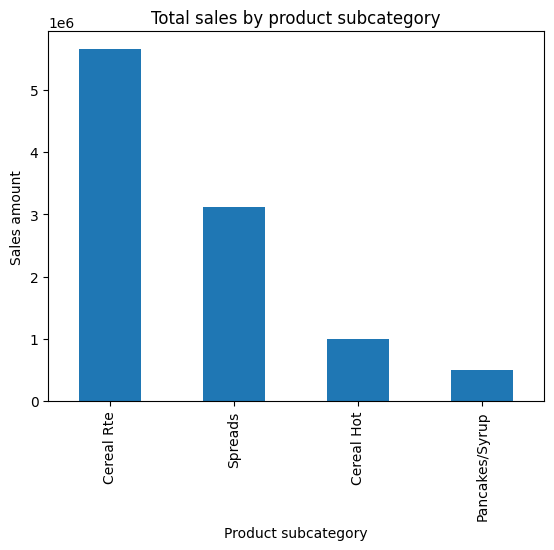

In [14]:
# Graph 1. Overall sales performance of different subcategories
import matplotlib.pyplot as plt
grouped = df.groupby('prod_subcategory')['sales_amt'].sum().sort_values(ascending = False)
grouped.plot(kind='bar')
plt.title('Total sales by product subcategory')
plt.xlabel('Product subcategory')
plt.ylabel('Sales amount')
plt.show()
# Cereal Rte is the bestseller among the breakfast subcategories

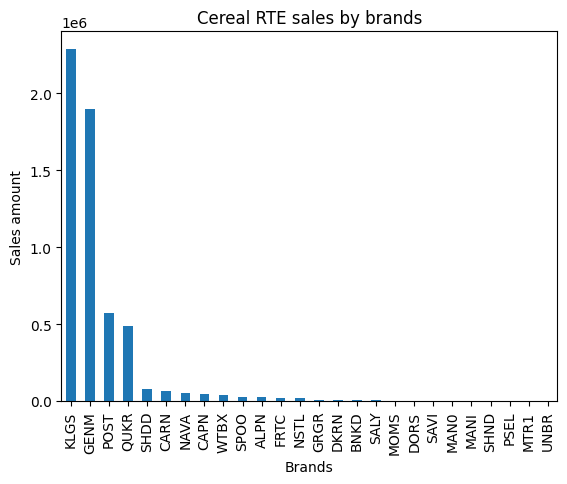

In [17]:
# Graph 2. Cereal Rte sales performance by brands
df_crte = df[df['prod_subcategory'] == "Cereal Rte"]
grouped = df_crte.groupby('prod_mfc_brand_cd')['sales_amt'].sum().sort_values(ascending = False)
grouped.plot(kind='bar')
plt.title('Cereal RTE sales by brands')
plt.xlabel('Brands')
plt.ylabel('Sales amount')
plt.show()
# KLGS and GENM are the top 2 brands for Cereal Rte (without ACSE) - They are dominating the Cereal RTE market in ACSE stores

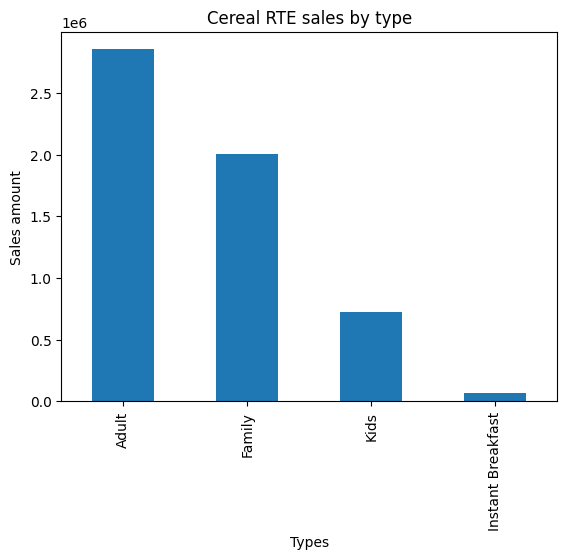

In [18]:
# Graph 3. Sales Performance of Different Types of Cereal Rte
grouped = df_crte.groupby('prod_type')['sales_amt'].sum().sort_values(ascending = False)
grouped.plot(kind='bar')
plt.title('Cereal RTE sales by type')
plt.xlabel('Types')
plt.ylabel('Sales amount')
plt.show()
# Adults Cereal Rte is the most popular type in Cereal Rte

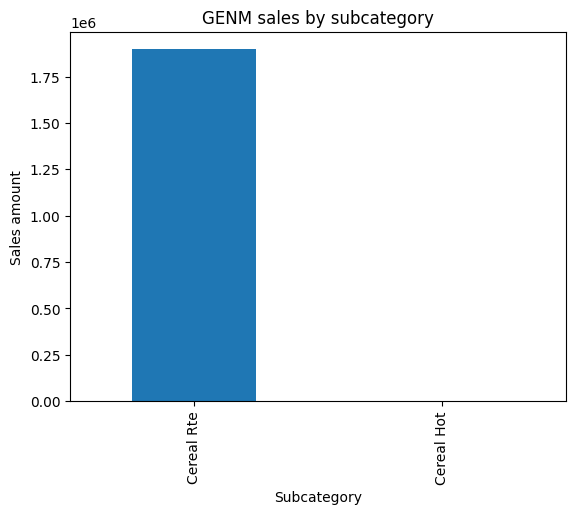

In [65]:
# Graph 4. Sales Distribution of GENM
df_genm = df[df['prod_mfc_brand_cd'] == "GENM"]
grouped = df_genm.groupby('prod_subcategory')['sales_amt'].sum().sort_values(ascending = False)
grouped.plot(kind='bar')
plt.title('GENM sales by subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Sales amount')
plt.show()

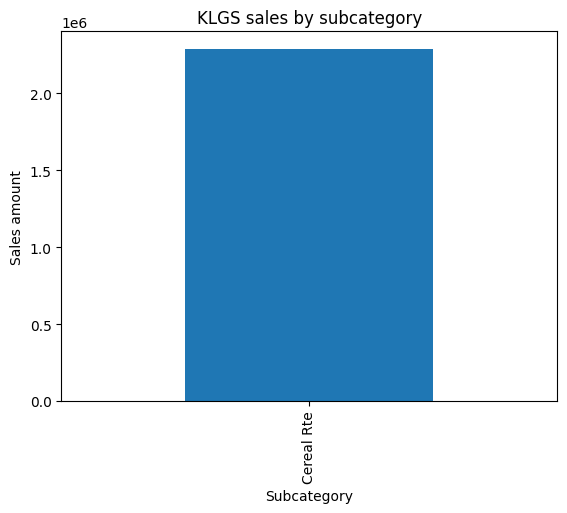

In [66]:
# Graph 5. Sales Distribution of KLGS
df_klgs = df[df['prod_mfc_brand_cd'] == "KLGS"]
grouped = df_klgs.groupby('prod_subcategory')['sales_amt'].sum().sort_values(ascending = False)
grouped.plot(kind='bar')
plt.title('KLGS sales by subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Sales amount')
plt.show()

Basically, GENM and KLGS are two Cereal Rte focused brands

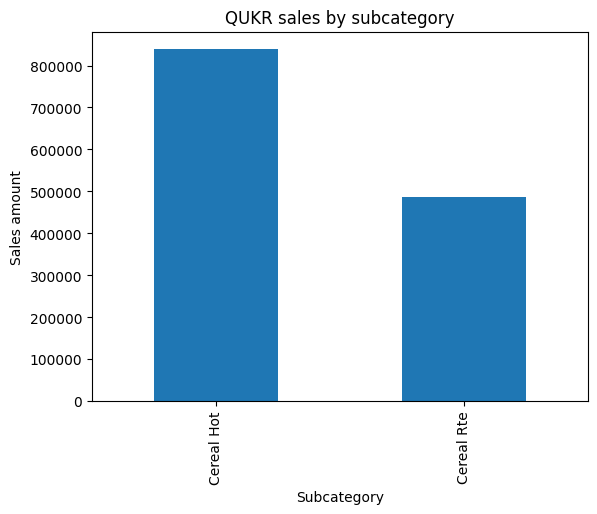

In [68]:
# Just FYI: QUKR's major sales lie in Cereal Hot subcategory
# Graph 6. Sales Distribution of QUKR
df_qukr = df[df['prod_mfc_brand_cd'] == "QUKR"]
grouped = df_qukr.groupby('prod_subcategory')['sales_amt'].sum().sort_values(ascending = False)
grouped.plot(kind='bar')
plt.title('QUKR sales by subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Sales amount')
plt.show()

## 2. Market Busket Analysis & Association Rules

### For different subcategories

In [20]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [49]:
# keep only relevant columns
df_mba = df[['cust_id', 'prod_subcategory', 'prod_mfc_brand_cd']]

# pivot table to create binary matrix
basket = (df_mba.groupby(['cust_id', 'prod_subcategory'])['prod_mfc_brand_cd']
          .count().unstack().reset_index().fillna(0)
          .set_index('cust_id'))

In [50]:
basket.head()

prod_subcategory,Cereal Hot,Cereal Rte,Pancakes/Syrup,Spreads
cust_id,,,,
1000006220,0.0,0.0,0.0,1.0
1000006497,0.0,7.0,0.0,4.0
1000007702,0.0,2.0,0.0,0.0
1000016138,0.0,0.0,0.0,2.0
1000016620,0.0,2.0,0.0,0.0


In [37]:
# Transform the subcategories lists into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(mba['subcategories']).transform(mba['subcategories'])
mba_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [39]:
mba_encoded.head()

,Cereal Hot,Cereal Rte,Pancakes/Syrup,Spreads
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,True,False,False
4,False,True,False,False


In [52]:
# convert binary values to boolean
def encode_units(x):
    if x <= 0:
        return False
    if x >= 1:
        return True
basket_sets = basket.applymap(encode_units)

In [53]:
# find frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

In [58]:
frequent_itemsets
# Interpretations:
# 1. Cereal Rte is the most frequently purchased subcategory, accounting for 68% transactions
# 2. For combinations, Cereal Rte & Spreads, Cereal Rte & Cereal Hot, Cereal Hot & Spreads are the 3 most frequently purchased combinations

,support,itemsets
0,0.261502,(Cereal Hot)
1,0.680347,(Cereal Rte)
2,0.129760,(Pancakes/Syrup)
3,0.526727,(Spreads)
4,0.158893,"(Cereal Rte, Cereal Hot)"
5,0.042332,"(Cereal Hot, Pancakes/Syrup)"
6,0.134020,"(Cereal Hot, Spreads)"
7,0.087587,"(Cereal Rte, Pancakes/Syrup)"
8,0.298136,"(Cereal Rte, Spreads)"
9,0.075091,"(Spreads, Pancakes/Syrup)"


In [55]:
# generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [57]:
# Sort rules by decreasing lift
rules = rules.sort_values(by=['lift'], ascending=False)
rules.head(10)
# Interpretations:
# Within the same category bucket, the four subcategories show strong relationships, no matter what the combination is, which is intuitively correct
# Based on the above result, we would like to further explore more information with application of MBA by different brands

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,"(Cereal Hot, Spreads)","(Cereal Rte, Pancakes/Syrup)",0.134020,0.087587,0.027684,0.206565,2.358402,0.015945,1.149953
34,"(Cereal Rte, Pancakes/Syrup)","(Cereal Hot, Spreads)",0.087587,0.134020,0.027684,0.316074,2.358402,0.015945,1.266189
32,"(Cereal Rte, Cereal Hot)","(Spreads, Pancakes/Syrup)",0.158893,0.075091,0.027684,0.174229,2.320230,0.015752,1.120055
37,"(Spreads, Pancakes/Syrup)","(Cereal Rte, Cereal Hot)",0.075091,0.158893,0.027684,0.368669,2.320230,0.015752,1.332275
36,"(Cereal Hot, Pancakes/Syrup)","(Cereal Rte, Spreads)",0.042332,0.298136,0.027684,0.653964,2.193505,0.015063,2.028294
33,"(Cereal Rte, Spreads)","(Cereal Hot, Pancakes/Syrup)",0.298136,0.042332,0.027684,0.092856,2.193505,0.015063,1.055696
41,(Pancakes/Syrup),"(Cereal Rte, Cereal Hot, Spreads)",0.129760,0.099099,0.027684,0.213347,2.152871,0.014825,1.145233
28,"(Cereal Rte, Cereal Hot, Spreads)",(Pancakes/Syrup),0.099099,0.129760,0.027684,0.279356,2.152871,0.014825,1.207587
16,"(Cereal Hot, Spreads)",(Pancakes/Syrup),0.134020,0.129760,0.031508,0.235100,1.811805,0.014118,1.137717
21,(Pancakes/Syrup),"(Cereal Hot, Spreads)",0.129760,0.134020,0.031508,0.242819,1.811805,0.014118,1.143689


### For different brands

In [59]:
# keep only relevant columns
df_mba = df[['cust_id', 'prod_mfc_brand_cd', 'trans_id']]

# pivot table to create binary matrix
basket = (df_mba.groupby(['cust_id', 'prod_mfc_brand_cd'])['trans_id']
          .count().unstack().reset_index().fillna(0)
          .set_index('cust_id'))

In [60]:
# convert binary values to boolean
def encode_units(x):
    if x <= 0:
        return False
    if x >= 1:
        return True
basket_sets = basket.applymap(encode_units)

In [64]:
# find frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(by=['support'], ascending=False).head(20)
# Interpretations:
# 1. GENM, KLGS and QUKR are the top 3 frequently purchased breakfast brands
# 2. GENM & KLGS, QUKR & KLGS, GENM & QUKR are the top 3 frequently purchased combinations
# 3. With consideration of total sales, seems like QUKR is a popular "supplement" in breakfast category

,support,itemsets
7,0.353562,(GENM)
8,0.349456,(KLGS)
17,0.312956,(QUKR)
9,0.294347,(KRFT)
16,0.165318,(POST)
21,0.156915,(SMCK)
43,0.151062,"(GENM, KLGS)"
53,0.118172,"(QUKR, KLGS)"
47,0.117832,"(GENM, QUKR)"
50,0.109002,"(KRFT, KLGS)"


In [69]:
# generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [71]:
# Sort rules by decreasing lift
rules = rules.sort_values(by=['lift'], ascending=False)
rules.head(10)
# Interpretations:
# 1. The confidence and lift data show that QUKR, AUNT and KRFT are highly potential to be purchased with purchase of KLGS and GENM

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
723,"(GENM, KRFT, KLGS)","(QUKR, AUNT)",0.062569,0.037026,0.010723,0.171376,4.628473,0.008406,1.162136
738,"(QUKR, AUNT)","(GENM, KRFT, KLGS)",0.037026,0.062569,0.010723,0.289597,4.628473,0.008406,1.319576
740,"(KLGS, AUNT)","(GENM, KRFT, QUKR)",0.045113,0.051636,0.010723,0.237684,4.603080,0.008393,1.244056
721,"(GENM, KRFT, QUKR)","(KLGS, AUNT)",0.051636,0.045113,0.010723,0.207661,4.603080,0.008393,1.205149
736,"(GENM, AUNT)","(KRFT, QUKR, KLGS)",0.044555,0.052388,0.010723,0.240663,4.593845,0.008389,1.247946
725,"(KRFT, QUKR, KLGS)","(GENM, AUNT)",0.052388,0.044555,0.010723,0.204679,4.593845,0.008389,1.201332
441,"(GENM, SMCK)","(KRFT, AUNT)",0.061588,0.036537,0.010042,0.163050,4.462592,0.007792,1.151160
444,"(KRFT, AUNT)","(GENM, SMCK)",0.036537,0.061588,0.010042,0.274841,4.462592,0.007792,1.294077
792,"(SMCK, GENM)","(KRFT, QUKR, KLGS)",0.061588,0.052388,0.014362,0.233202,4.451430,0.011136,1.235804
789,"(KRFT, QUKR, KLGS)","(SMCK, GENM)",0.052388,0.061588,0.014362,0.274153,4.451430,0.011136,1.292852


### 3. Modeling

In [72]:
df.head()

,cust_id,trans_id,trans_dt,store_id,prod_id,sales_amt,sales_qty,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,crte_label,brand_label
0,1125342721,201030014242100236,2020-10-30,1424,21245022,9.99,1,Breakfast,Cereal Hot,Standard,MCAN,0,0
1,1152679965,200723010270806505,2020-07-23,1027,21241003,18.99,1,Breakfast,Pancakes/Syrup,Syrup,JAKE,0,0
2,1129904446,191217010270900830,2019-12-17,1027,20067857002,4.99,1,Breakfast,Spreads,Fruit,WLCH,0,0
3,1127436140,180413010270807345,2018-04-13,1027,20309886001,3.99,1,Breakfast,Spreads,Fruit,RBTS,0,0
4,1105124875,190119010270106857,2019-01-19,1027,20751615,2.99,1,Breakfast,Cereal Rte,Adult,SPOO,1,0


In [73]:
# Index and encode the columns for modeling
from sklearn.preprocessing import LabelEncoder
cols = ['store_id', 'prod_id', 'prod_category', 'prod_subcategory', 'prod_type', 'prod_mfc_brand_cd']
encoder = LabelEncoder()
for col in cols:
    df[col] = encoder.fit_transform(df[col])

In [74]:
df.head()

,cust_id,trans_id,trans_dt,store_id,prod_id,sales_amt,sales_qty,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,crte_label,brand_label
0,1125342721,201030014242100236,2020-10-30,46,593,9.99,1,0,0,9,76,0,0
1,1152679965,200723010270806505,2020-07-23,15,590,18.99,1,0,2,11,57,0,0
2,1129904446,191217010270900830,2019-12-17,15,644,4.99,1,0,3,2,130,0,0
3,1127436140,180413010270807345,2018-04-13,15,741,3.99,1,0,3,2,103,0,0
4,1105124875,190119010270106857,2019-01-19,15,190,2.99,1,0,1,0,121,1,0


In [81]:
import implicit
from scipy import sparse

In [79]:
# Create a user-item matrix
user_item_matrix = df.pivot_table(index='cust_id', columns='prod_id', values='sales_amt', fill_value=0)

In [82]:
# Convert the user-item matrix to a sparse matrix
sparse_user_item = sparse.csr_matrix(user_item_matrix.values)

In [84]:
# Initialize the model
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.01, iterations=50)

In [ ]:
# Fit the model to the sparse user-item matrix
model.fit(sparse_user_item)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Get the item factors matrix
item_factors = model.item_factors
# Get the user factors matrix
user_factors = model.user_factors

In [ ]:
# Predict the scores for a particular user
user_id = '1125342721'
user_idx = user_item_matrix.index.get_loc(user_id)
user_vector = user_factors[user_idx]
scores = user_vector.dot(item_factors.T)
sorted_indices = np.argsort(scores)[::-1]
top_items = sorted_indices[:10]